In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
from scipy.linalg import solve

In [11]:
CCOFile = 'Tree.cco'

In [177]:
def Viscosity(d, hd=0.45):
    mu045 = 220*np.exp(-1.3*d) + 3.2 - 2.44*np.exp(-0.06*d*0.645)
    C = (0.8 + np.exp(-0.075*d))*(-1+(1+10**-11*(d)**12)**-1)+(1+10**-11*(d)**12)**-1
    return 1 + (mu045-1)*((1-hd)**C-1)/((1-0.45)**C-1)

In [237]:
def ReadCCO(CCOFile):
    
    SegmentsData = []
    DistalNodes  = dict()
    
    nodeName = -1

    with open(CCOFile, 'r') as f:
        f.readline()
        f.readline()
        f.readline()
        f.readline()

        nVessels = int(f.readline())

        for i in range(nVessels):
            
            row = (f.readline()).split()
       
            if int(row[-1]) >= -2:
                
                nodeName+=1
                DistalNodes[int(row[0])] = nodeName
                
                SegmentsData.append([int(row[0]),
                                     np.array([float(x) for x in row[1:4]]), 
                                     np.array([float(x) for x in row[4:7]]),
                                     float(row[12]),
                                     float(row[13]),
                                     nodeName,
                                     int(row[-1])]) # Id, xProx, xDist, radius, initial flow, distalNode, stage
        
        df = pd.DataFrame(SegmentsData, columns=['Id', 'xProx', 'xDist', 'Radius', 'InitFlow','DistalNode','Stage'])
        df['Inlet'] = False
        df['Outlet'] = False
        df = df.set_index('Id')
        
        f.readline()
        f.readline()
        
        NodesConnections = []
        SegNewName = -1
        for i in range(nVessels):
            row = (f.readline()).split()
            SegmentId, ParentId, BranchesIds = int(row[0]), int(row[1]), [int(x) for x in row[2:]]

            if SegmentId in DistalNodes:    
                ProximalNode = DistalNodes[SegmentId]
                for connection in BranchesIds:
                    DistalNode = DistalNodes[connection]
                    SegNewName +=1
                    NodesConnections.append((ProximalNode, DistalNode, SegNewName, connection))
                    
                
                if not BranchesIds:
                    df.at[SegmentId, 'Outlet'] = True
                
                if not ParentId in DistalNodes: # Inlet node, need to add the proximal node to the tree
                    df.at[SegmentId, 'Inlet'] = True
                    nodeName+=1
                    SegNewName +=1
                    NodesConnections.append((nodeName, DistalNodes[SegmentId], SegNewName, SegmentId))

    ConnectivityMatrix = np.zeros((nodeName+1, len(SegmentsData)))
    Radii  = np.zeros((len(SegmentsData),))
    Length = np.zeros((len(SegmentsData),))
    df['SegName'] = df.index
    df['Id'] = df.index
    D = np.zeros((nodeName+1,nodeName+1)) # Decision matrix

    for proxNode, distNode, SegmentName, SegmentId in NodesConnections:
        
        ConnectivityMatrix[proxNode, SegmentName] = 1
        ConnectivityMatrix[distNode, SegmentName] = -1
        Radii[SegmentName] = df.at[SegmentId, 'Radius']
        xProx, xDist = df.at[SegmentId, 'xProx'], df.at[SegmentId, 'xDist']
        Length[SegmentName] = sum([(xProx[i]-xDist[i])**2 for i in range(3)])**.5
        
        df.at[SegmentId, 'SegName'] = SegmentName
        if df.at[SegmentId, 'Inlet']:
            D[proxNode, proxNode] = 1
        elif df.at[SegmentId, 'Outlet']:
            D[distNode, distNode] = -1
    
    df = df.set_index('SegName')
    
    return ConnectivityMatrix.T, Radii, Length, D, df

In [238]:
Connectivity, Radii, Length, D, df = ReadCCO(CCOFile)
df

,xProx,xDist,Radius,InitFlow,DistalNode,Stage,Inlet,Outlet,Id
SegName,,,,,,,,,
2,"[-0.6, 0.0, 0.0]","[-0.22499999999999998, 0.0, 0.0]",0.004000,0.0,0,-2,True,False,0
0,"[-0.22499999999999998, 0.0, 0.0]","[-0.22499999999999998, 0.04875, 0.0]",0.003165,0.0,1,-2,False,False,1
3,"[-0.22499999999999998, 0.04875, 0.0]","[-0.22499999999999998, 0.0975, 0.0]",0.002682,0.0,2,-2,False,False,2
5,"[-0.22499999999999998, 0.0975, 0.0]","[-0.22499999999999998, 0.14625, 0.0]",0.002682,0.0,3,-2,False,False,3
6,"[-0.22499999999999998, 0.14625, 0.0]","[-0.22499999999999998, 0.195, 0.0]",0.002682,0.0,4,-2,False,False,4
...,...,...,...,...,...,...,...,...,...
802,"[-0.102, -0.03899999999999999, 0.0]","[-0.096, -0.03699999999999999, 0.0]",0.000585,0.0,802,-1,False,False,202
803,"[-0.096, -0.03699999999999999, 0.0]","[-0.086, -0.03499999999999999, 0.0]",0.000585,0.0,803,-1,False,False,203
804,"[-0.086, -0.03499999999999999, 0.0]","[-0.07999999999999999, -0.031, 0.0]",0.000585,0.0,804,-1,False,False,204


In [239]:
narcs, nnodes = Connectivity.shape
R = np.zeros((narcs,narcs))
for i in range(narcs):
    r,l = Radii[i], Length[i]
    mu  = Viscosity(2*r) 
    R[i,i] = 8.0*mu*l/(np.pi*(r**4))

In [255]:
# Add the boundary conditions
qperf = 0.3 # muL/min
qcap  = 0.1 # muL/min

# RHS for flow rates: qbar = qperf if inlet node, -qcap otherwise
qbar = np.ones((nnodes,)) # Flow rate at nodes
qbar = np.matmul(D,qbar)
qbar[qbar>0] *= qperf
qbar[qbar<0] *= qcap

<ipython-input-258-536f77dba0e9>:7: LinAlgWarning: Ill-conditioned matrix (rcond=2.28721e-43): result may not be accurate.
  x = solve(M,RHS)


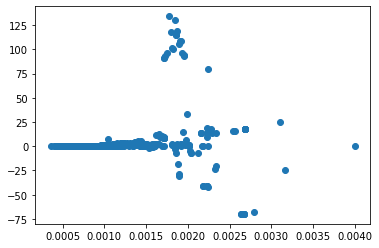

In [258]:
# Solve the system
M = np.block([[
    R, -Connectivity],
    [Connectivity.T, D*0]])

RHS = np.concatenate([np.zeros(narcs,), qbar])
x = solve(M,RHS)
plt.scatter(Radii, x[:narcs])